# Train decoder

## Dataset loading

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

Load the dataset with hugging face and split between train and test.

In [2]:
ds = load_dataset('json', data_files='/home/ubuntu/data/intestinal_organoid_dataset/one_mask_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)

Define the local folder where the dataset is located.

In [3]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/intestinal_organoid_dataset/"

Define the processor (encoder) of SAM.

In [4]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [5]:
from utils.sam_dataset import SAMDataset
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)
del(test_dataset)

In [6]:
item = sam_test_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask', 'original_image'])


### Create PyTorch dataloader

In [7]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(sam_test_dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)
del(k, v)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 450, 450])
original_image torch.Size([1, 450, 450, 3])


/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [9]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

See first mask prediction.

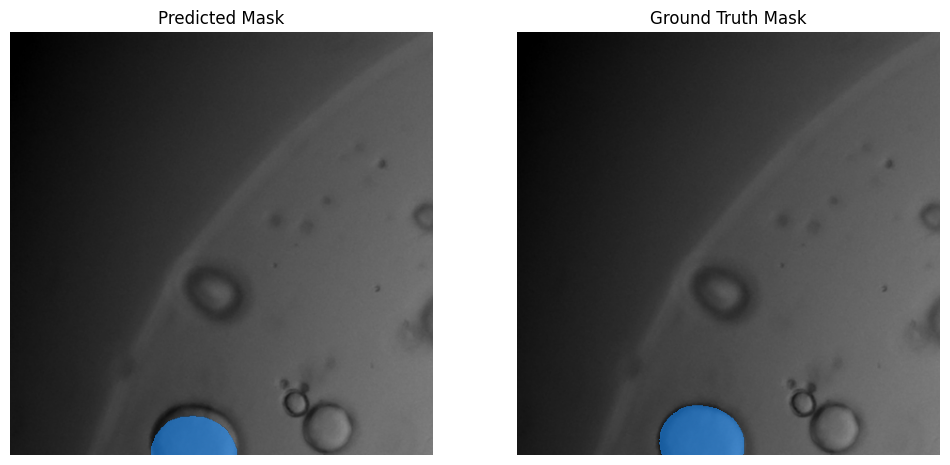

In [10]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute mask
outputs = model(pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False)
# Post-process mask
predicted_masks = outputs.pred_masks.to(device)
predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                mode="bilinear", align_corners=False)
predicted_masks = predicted_masks[..., :992, :1024]
predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                mode="bilinear", align_corners=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
# apply sigmoid
mask_seg_prob = torch.sigmoid(predicted_masks)
# convert soft mask to hard mask
mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
show_mask(first_mask_seg, axes[0])
axes[0].set_title("Predicted Mask")
axes[0].axis("off")

# Plot Ground Truth Mask
ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
axes[1].imshow(np.array(batch["original_image"]).squeeze())
show_mask(ground_truth_masks, axes[1])
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

plt.show()

### Train the model

In [ ]:
from torch.optim import Adam
import monai
from utils.model_training import train_model


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# Define geometrical loss
geom_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 200
# Define parameters for topological loss
topo_param = {'lamda': 1.0, 
              'interp': 0, 
              'feat_d': 1, 
              'loss_q': 2, 
              'loss_r': False}

In [11]:
# Run training function
train_model(model = model, optimizer = optimizer, geometric_loss = geom_loss, 
            dataloader = test_dataloader, num_epochs = num_epochs, device = device,
            topological_loss = True, topo_param = topo_param)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


EPOCH: 1
Mean loss: 0.3508494198322296


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 2
Mean loss: 0.26358336210250854


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 3
Mean loss: 0.26558053493499756


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 4
Mean loss: 0.1927472949028015


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 5
Mean loss: 0.1942940056324005


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 6
Mean loss: 0.19254207611083984


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 7
Mean loss: 0.3229312300682068


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 8
Mean loss: 0.18051208555698395


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 9
Mean loss: 0.26283174753189087


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 10
Mean loss: 0.17642386257648468


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 11
Mean loss: 0.17943903803825378


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 12
Mean loss: 0.27897679805755615


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 13
Mean loss: 0.16164392232894897


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 14
Mean loss: 0.16626180708408356


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 15
Mean loss: 0.16129645705223083


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 16
Mean loss: 0.14719969034194946


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 17
Mean loss: 0.1530522108078003


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 18
Mean loss: 0.1533423811197281


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 19
Mean loss: 0.14792218804359436


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 20
Mean loss: 0.15403857827186584


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 21
Mean loss: 0.14519041776657104


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 22
Mean loss: 0.14037135243415833


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 23
Mean loss: 0.1111319288611412


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 24
Mean loss: 0.13348516821861267


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 25
Mean loss: 0.12811338901519775


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 26
Mean loss: 0.1435520052909851


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 27
Mean loss: 0.12445102632045746


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 28
Mean loss: 0.1542523056268692


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 29
Mean loss: 0.11392603814601898


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 30
Mean loss: 0.11155930161476135


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 31
Mean loss: 0.13512611389160156


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 32
Mean loss: 0.10983749479055405


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 33
Mean loss: 0.10012517869472504


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH: 34
Mean loss: 0.11778609454631805


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 35
Mean loss: 0.08584943413734436


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 36
Mean loss: 0.08546337485313416


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 37
Mean loss: 0.11446302384138107


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 38
Mean loss: 0.07441085577011108


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 39
Mean loss: 0.0785660520195961


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 40
Mean loss: 0.077615886926651


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 41
Mean loss: 0.06743783503770828


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 42
Mean loss: 0.07082557678222656


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 43
Mean loss: 0.07663477212190628


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 44
Mean loss: 0.08203605562448502


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 45
Mean loss: 0.062021851539611816


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 46
Mean loss: 0.05844283103942871


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 47
Mean loss: 0.07532460987567902


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 48
Mean loss: 0.054289236664772034


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 49
Mean loss: 0.057430699467659


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 50
Mean loss: 0.04976816847920418


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 51
Mean loss: 0.04896405711770058


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 52
Mean loss: 0.05346442013978958


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 53
Mean loss: 0.04785575717687607


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH: 54
Mean loss: 0.0499512143433094


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 55
Mean loss: 0.04396499693393707


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 56
Mean loss: 0.05154576152563095


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 57
Mean loss: 0.05362079665064812


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 58
Mean loss: 0.050278667360544205


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 59
Mean loss: 0.049453478306531906


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 60
Mean loss: 0.06649437546730042


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 61
Mean loss: 0.07118351757526398


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 62
Mean loss: 0.04100097343325615


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 63
Mean loss: 0.041946202516555786


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 64
Mean loss: 0.04658714681863785


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 65
Mean loss: 0.04063652455806732


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 66
Mean loss: 0.046913087368011475


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 67
Mean loss: 0.0527174212038517


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 68
Mean loss: 0.034076038748025894


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 69
Mean loss: 0.03237301856279373


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 70
Mean loss: 0.042301394045352936


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 71
Mean loss: 0.033940114080905914


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 72
Mean loss: 0.039085738360881805


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 73
Mean loss: 0.05223289504647255


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 74
Mean loss: 0.036112356930971146


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 75
Mean loss: 0.03567489609122276


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 76
Mean loss: 0.0455641895532608


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 77
Mean loss: 0.03304894268512726


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 78
Mean loss: 0.04706753045320511


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 79
Mean loss: 0.03628924861550331


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 80
Mean loss: 0.03306914120912552


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 81
Mean loss: 0.029954716563224792


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 82
Mean loss: 0.03452720865607262


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 83
Mean loss: 0.041934866458177567


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 84
Mean loss: 0.0434253104031086


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 85
Mean loss: 0.030388545244932175


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 86
Mean loss: 0.029309507459402084


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 87
Mean loss: 0.035760484635829926


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 88
Mean loss: 0.03682870790362358


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 89
Mean loss: 0.030256712809205055


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 90
Mean loss: 0.03198222070932388


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 91
Mean loss: 0.035140510648489


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH: 92
Mean loss: 0.03194313496351242


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 93
Mean loss: 0.028111116960644722


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 94
Mean loss: 0.043816398829221725


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 95
Mean loss: 0.033544156700372696


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 96
Mean loss: 0.03722177818417549


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 97
Mean loss: 0.039750125259160995


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 98
Mean loss: 0.04040798544883728


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 99
Mean loss: 0.028848249465227127


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 100
Mean loss: 0.030268147587776184


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 101
Mean loss: 0.03393787518143654


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH: 102
Mean loss: 0.03127285838127136


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 103
Mean loss: 0.035317208617925644


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 104
Mean loss: 0.042278241366147995


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 105
Mean loss: 0.0332287922501564


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 106
Mean loss: 0.03016474097967148


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 107
Mean loss: 0.029647253453731537


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 108
Mean loss: 0.028755176812410355


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 109
Mean loss: 0.03395476192235947


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 110
Mean loss: 0.025393305346369743


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 111
Mean loss: 0.025777649134397507


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 112
Mean loss: 0.030676018446683884


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 113
Mean loss: 0.035042110830545425


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 114
Mean loss: 0.043159473687410355


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 115
Mean loss: 0.027719372883439064


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 116
Mean loss: 0.038683466613292694


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 117
Mean loss: 0.02830156870186329


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 118
Mean loss: 0.02597755193710327


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH: 119
Mean loss: 0.020909516140818596


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 120
Mean loss: 0.024757618084549904


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 121
Mean loss: 0.029255418106913567


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 122
Mean loss: 0.02409966103732586


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 123
Mean loss: 0.026677684858441353


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 124
Mean loss: 0.025829561054706573


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 125
Mean loss: 0.02558513917028904


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 126
Mean loss: 0.02620161511003971


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 127
Mean loss: 0.026279060170054436


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 128
Mean loss: 0.02533932961523533


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 129
Mean loss: 0.024267863482236862


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 130
Mean loss: 0.02847471460700035


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 131
Mean loss: 0.020671000704169273


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 132
Mean loss: 0.024698935449123383


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 133
Mean loss: 0.02555953338742256


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 134
Mean loss: 0.024668080732226372


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 135
Mean loss: 0.02634676732122898


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 136
Mean loss: 0.026838049292564392


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 137
Mean loss: 0.022941019386053085


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 138
Mean loss: 0.02994775027036667


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 139
Mean loss: 0.025680074468255043


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 140
Mean loss: 0.03269244730472565


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 141
Mean loss: 0.025514692068099976


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 142
Mean loss: 0.02677975222468376


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 143
Mean loss: 0.02435019239783287


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 144
Mean loss: 0.022909972816705704


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 145
Mean loss: 0.021556787192821503


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 146
Mean loss: 0.022613607347011566


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 147
Mean loss: 0.030530191957950592


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 148
Mean loss: 0.02111946977674961


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 149
Mean loss: 0.021777508780360222


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 150
Mean loss: 0.02686777152121067


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 151
Mean loss: 0.021722160279750824


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 152
Mean loss: 0.01915629208087921


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 153
Mean loss: 0.021611148491501808


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 154
Mean loss: 0.022763032466173172


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 155
Mean loss: 0.023643936961889267


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 156
Mean loss: 0.022386275231838226


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 157
Mean loss: 0.02026107907295227


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 158
Mean loss: 0.01767849735915661


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 159
Mean loss: 0.02380494587123394


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 160
Mean loss: 0.026117831468582153


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 161
Mean loss: 0.01883738674223423


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 162
Mean loss: 0.027655845507979393


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 163
Mean loss: 0.020481949672102928


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 164
Mean loss: 0.018526475876569748


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 165
Mean loss: 0.020112544298171997


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 166
Mean loss: 0.01920744776725769


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 167
Mean loss: 0.020294710993766785


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 168
Mean loss: 0.02305835485458374


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 169
Mean loss: 0.025140132755041122


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 170
Mean loss: 0.02010718174278736


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


EPOCH: 171
Mean loss: 0.0180073119699955


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 172
Mean loss: 0.017272701486945152


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 173
Mean loss: 0.018762938678264618


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 174
Mean loss: 0.021798769012093544


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 175
Mean loss: 0.016313910484313965


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH: 176
Mean loss: 0.020694876089692116


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 177
Mean loss: 0.019299540668725967


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 178
Mean loss: 0.01857680454850197


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 179
Mean loss: 0.01983620412647724


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 180
Mean loss: 0.018879663199186325


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 181
Mean loss: 0.017322152853012085


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 182
Mean loss: 0.019713062793016434


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH: 183
Mean loss: 0.018490198999643326


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 184
Mean loss: 0.017344679683446884


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 185
Mean loss: 0.01780392974615097


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH: 186
Mean loss: 0.01648947037756443


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 187
Mean loss: 0.020347503945231438


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 188
Mean loss: 0.015221918001770973


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH: 189
Mean loss: 0.01588582433760166


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 190
Mean loss: 0.022987347096204758


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH: 191
Mean loss: 0.018193406984210014


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 192
Mean loss: 0.017601173371076584


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 193
Mean loss: 0.019264088943600655


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 194
Mean loss: 0.017131458967924118


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH: 195
Mean loss: 0.017316659912467003


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH: 196
Mean loss: 0.0164553951472044


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH: 197
Mean loss: 0.016915960237383842


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH: 198
Mean loss: 0.018071217462420464


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH: 199
Mean loss: 0.015470730140805244


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

EPOCH: 200
Mean loss: 0.01706816628575325


See now the results.

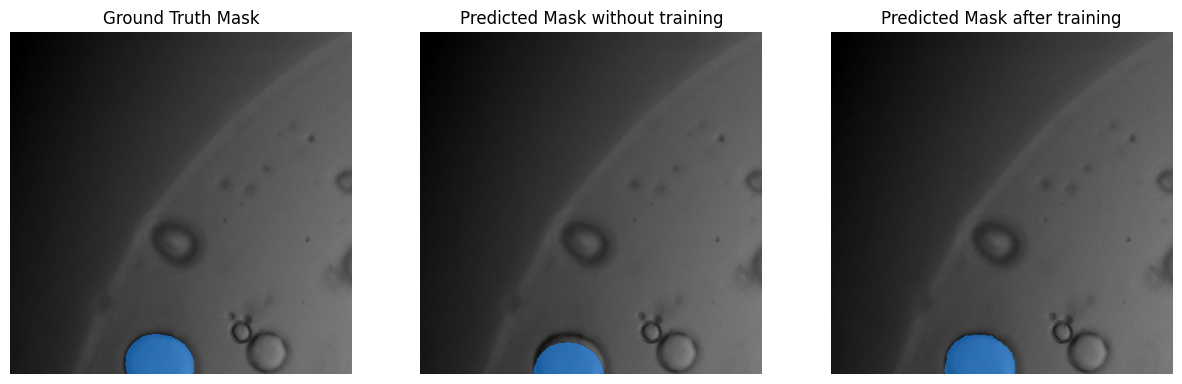

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute mask
outputs = model(pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False)
# Post-process mask
predicted_masks = outputs.pred_masks.to(device)
predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                mode="bilinear", align_corners=False)
predicted_masks = predicted_masks[..., :992, :1024]
predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                mode="bilinear", align_corners=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth Mask
ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
axes[0].imshow(np.array(batch["original_image"]).squeeze())
show_mask(ground_truth_masks, axes[0])
axes[0].set_title("Ground Truth Mask")
axes[0].axis("off")

# Plot initial predicted mask
axes[1].imshow(np.array(batch["original_image"]).squeeze())
show_mask(first_mask_seg, axes[1])
axes[1].set_title("Predicted Mask without training")
axes[1].axis("off")

# Plot predicted mask after training
axes[2].imshow(np.array(batch["original_image"]).squeeze())
# apply sigmoid
mask_seg_prob = torch.sigmoid(predicted_masks)
# convert soft mask to hard mask
mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
show_mask(mask_seg, axes[2])
axes[2].set_title("Predicted Mask after training")
axes[2].axis("off")

plt.show()